## Comparison of ways to calculate the IDD
In this notebook we compare the various ways the IDDs per course can be calculated from the microdata (see the [previous notebook](3-CalculateIDDs.ipynb))

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Variables with `inep` in them are calculated according to the (erroneous) INEP methodology, which take the "random intercept" model and averages the residues. The `intercept` IDDs are calculated by taking the "random intercept" model and taking the intercepts estimated by the model as the IDD. The `noranef` IDDs ("no random effects") are calculated by taking again the same "random intercept" model, but this time average different residues. We now calculate residues against the overall best linear fit, and again average them to get to the IDD of the course. 

In [2]:
areas = pd.read_csv('data/calculated/areas14-17.csv')

idd_calc_inep17 = pd.concat([pd.read_csv('data/calculated/idd-'+'ml-'+'2017-'+str(area)+'.csv') for area in areas['areas14-17']])
idd_calc_inep14 = pd.concat([pd.read_csv('data/calculated/idd-'+'ml-'+'2014-'+str(area)+'.csv') for area in areas['areas14-17']])

idd_calc_intercept17 = pd.concat([pd.read_csv('data/calculated/idd-'+'intercept-'+'2017-'+str(area)+'.csv') for area in areas['areas14-17']])
idd_calc_intercept14 = pd.concat([pd.read_csv('data/calculated/idd-'+'intercept-'+'2014-'+str(area)+'.csv') for area in areas['areas14-17']])

idd_calc_noranef17 = pd.concat([pd.read_csv('data/calculated/idd-'+'noranef-'+'2017-'+str(area)+'.csv') for area in areas['areas14-17']])
idd_calc_noranef14 = pd.concat([pd.read_csv('data/calculated/idd-'+'noranef-'+'2014-'+str(area)+'.csv') for area in areas['areas14-17']])



In [3]:
def mergeidd(df1,df2,on=['curso'],validate='1:1',newcols={}):
    ''
    df = pd.merge(df1,df2,on=on,how='inner',validate=validate)
    df.rename(columns=newcols,inplace=True)
    print("courses: ",len(df))
    return df

Let's calculate all the correlations.

In [4]:
df = mergeidd(idd_calc_intercept17,idd_calc_noranef17,newcols={'idd_x':'idd_intercept17','idd_y':'idd_noranef17'})
df = mergeidd(df,idd_calc_inep17,newcols={'idd':'idd_inep17'})
df = mergeidd(df,idd_calc_inep14,newcols={'idd':'idd_inep14'})
df = mergeidd(df,idd_calc_intercept14,newcols={'idd':'idd_intercept14'})
df = mergeidd(df,idd_calc_noranef14,newcols={'idd':'idd_noranef14'})
df[['idd_intercept17','idd_noranef17','idd_inep17','idd_intercept14','idd_noranef14','idd_inep14']].corr()

courses:  9333
courses:  9333
courses:  6294
courses:  6294
courses:  6294


,idd_intercept17,idd_noranef17,idd_inep17,idd_intercept14,idd_noranef14,idd_inep14
idd_intercept17,1.000000,0.937741,0.606940,0.354871,0.346451,0.252666
idd_noranef17,0.937741,1.000000,0.813340,0.325897,0.333886,0.259796
idd_inep17,0.606940,0.813340,1.000000,0.226401,0.249317,0.230805
idd_intercept14,0.354871,0.325897,0.226401,1.000000,0.939265,0.642173
idd_noranef14,0.346451,0.333886,0.249317,0.939265,1.000000,0.818892
idd_inep14,0.252666,0.259796,0.230805,0.642173,0.818892,1.000000


Note que high correlation between `intercept` and `noranef`, showing that these methods are very similar. The correlations between 2014 and 2017 of these better methods of calculating IDD and the INEP one increases from 0.22 to 0.35. 

Next, let's disaggregate the correlations per area.

In [5]:
newcols = {'idd_x':'idd17','idd_y':'idd14','area_x':'area','area_y':'area14'}
df_inep = mergeidd(idd_calc_inep17,idd_calc_inep14,newcols=newcols)
df_intercept = mergeidd(idd_calc_intercept17,idd_calc_intercept14,newcols=newcols)
df_noranef = mergeidd(idd_calc_noranef17,idd_calc_noranef14,newcols=newcols)

courses:  6294
courses:  6294
courses:  6294


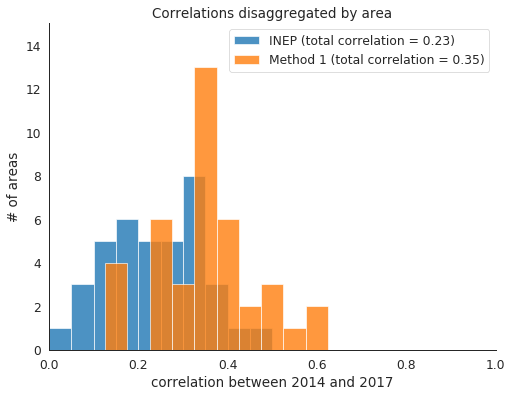

In [6]:
fig = plt.figure(figsize=(8,6))
sns.set_context('paper',font_scale=1.4)
sns.set_style('white')
alpha = 0.8
bins = np.arange(0,1,.05)

def corrfig(methods=['inep','intercept'],savefig=False):
    for method in methods:
        if method == 'inep':
            corr = df_inep[['idd14','idd17']].corr().iloc[0,1]
            corrs = df_inep[['area','idd14','idd17']].groupby('area').corr().iloc[0::2,-1].sort_values()
            corrs.hist(label="INEP (total correlation = {:.2f})".format(corr),alpha=alpha,bins=bins)
        elif method == 'intercept':
            corr = df_intercept[['idd14','idd17']].corr().iloc[0,1]
            corrs = df_intercept[['area','idd14','idd17']].groupby('area').corr().iloc[0::2,-1].sort_values()
            corrs.hist(label="Method 1 (total correlation = {:.2f})".format(corr),alpha=alpha,bins=bins+0.025)
        elif method == 'noranef':
            corr = df_noranef[['idd14','idd17']].corr().iloc[0,1]
            corrs = df_noranef[['area','idd14','idd17']].groupby('area').corr().iloc[0::2,-1].sort_values()
            corrs.hist(label="Method 2 (total correlation = {:.2f})".format(corr),alpha=alpha,bins=bins)
    
    ax = plt.gca()
    ax.set_title("Correlations disaggregated by area")
    ax.set_ylim(0,15)
    ax.set_xlim(0,1)
    ax.set_ylabel("# of areas")
    ax.set_xlabel("correlation between 2014 and 2017")
    ax.grid(False)
    plt.legend()
    sns.despine()
    if savefig:
        for dpi in [50,100,300]:
            fn = 'figs/corrs-compare-14-17-{}.png'.format(dpi)
            plt.savefig(fn,dpi=dpi)

corrfig(['inep','intercept'],savefig=True)

/home/ewout/.conda/envs/idd/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


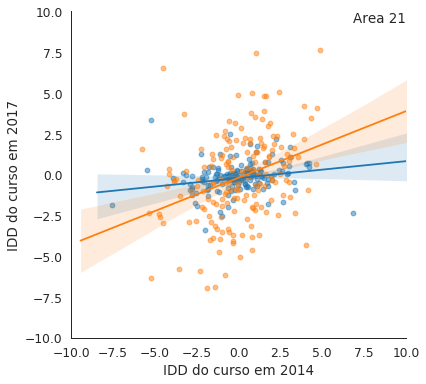

In [8]:
area=21
fig = plt.figure(figsize=(6,6))
sns.regplot(data=df_inep.query("area == @area"),x='idd14',y='idd17',scatter_kws={'alpha':0.5})
sns.regplot(data=df_intercept.query("area == 21"),x='idd14',y='idd17',scatter_kws={'alpha':0.5})
ax = plt.gca()
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_xlabel("IDD do curso em 2014")
ax.set_ylabel("IDD do curso em 2017")
ax.text(1,1,"Area " + str(area),
            horizontalalignment='right',
            verticalalignment='top',transform=ax.transAxes);
sns.despine()

for dpi in [50,300]:
     fn = 'figs/corr-comp-21-14-17-{}.png'.format(dpi)
     plt.savefig(fn,dpi=dpi)

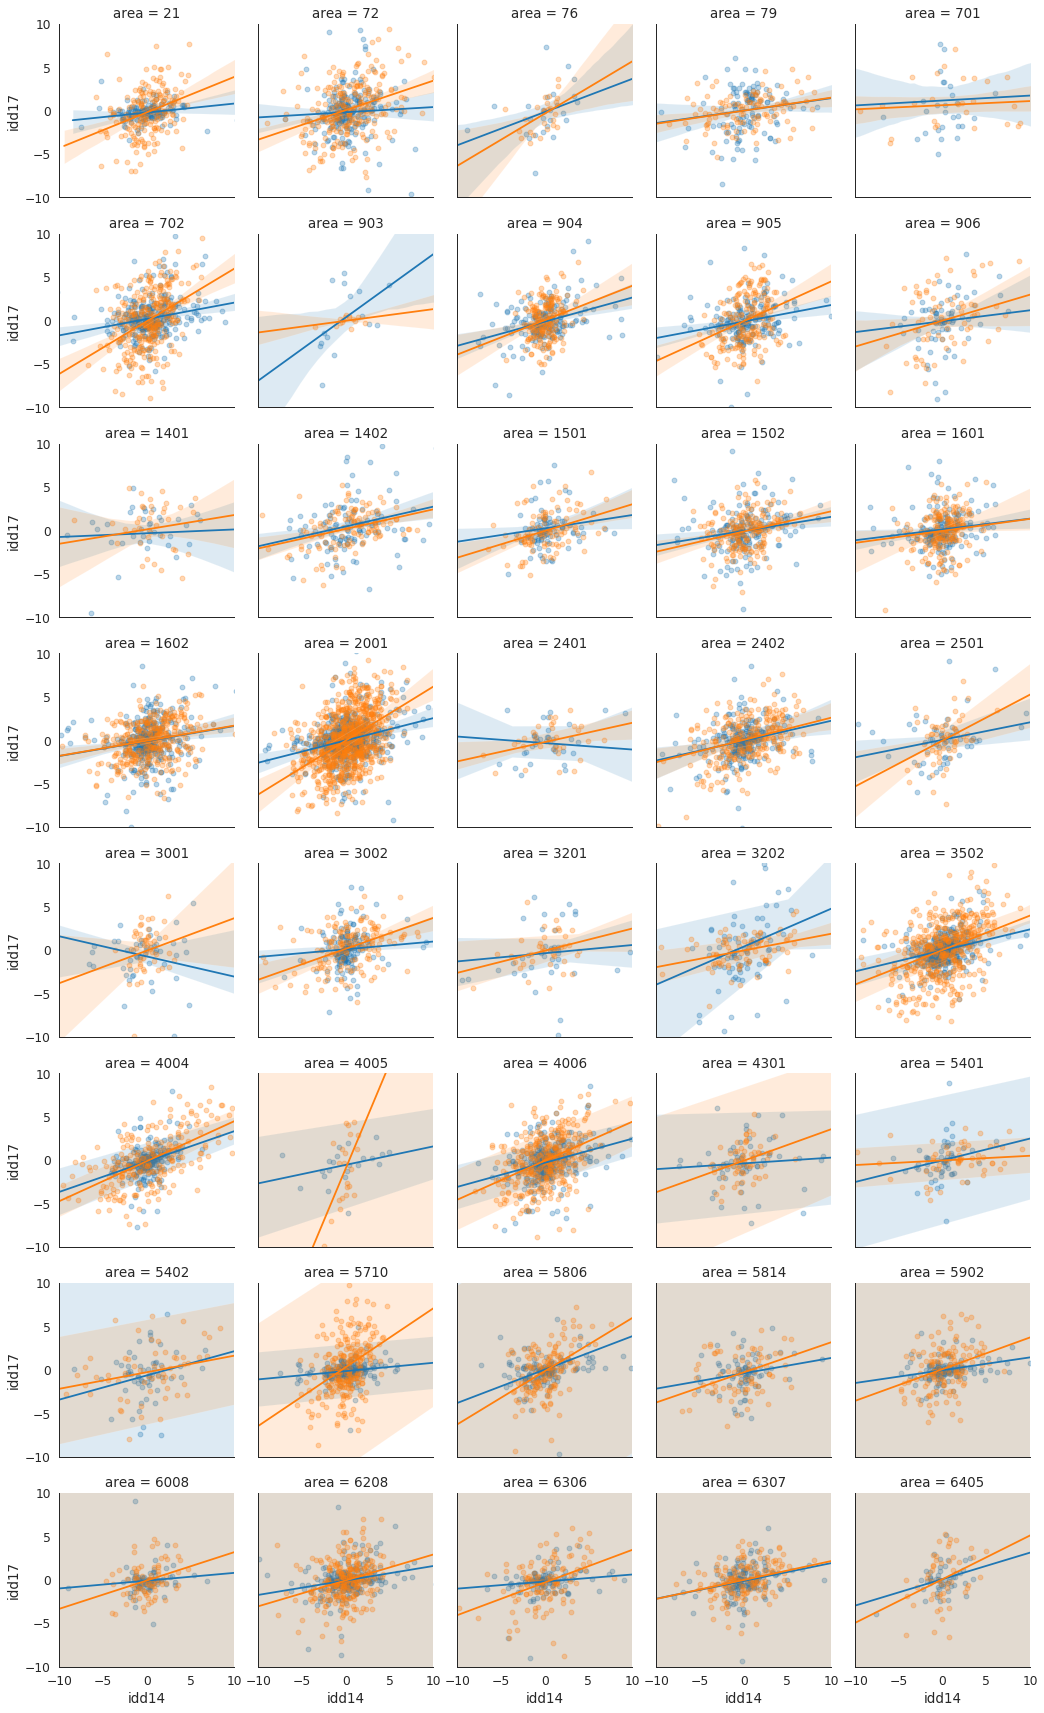

In [9]:
df_inep['method'] = 'inep'
df_intercept['method'] = 'intercept'
df = pd.concat([df_inep,df_intercept])
g = sns.FacetGrid(df,col='area',height=3,col_wrap=5,hue='method')
g.map(sns.regplot,'idd14','idd17',scatter_kws={'alpha':0.3});
g.set(xlim=(-10,10))
g.set(ylim=(-10,10))